# Librerias

In [ ]:
import torch
#These are the basic building blocks for graph
import torch.nn as nn   
#The torchvision package consists of popular datasets, 
#model architectures, and common image transformations for computer vision.
import torchvision


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Trabajando con el CPU o GPU

In [ ]:
#trabajando con el cpu
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Data

In [ ]:
#descarga dataset de kaggle
!mkdir .kaggle
!mv kaggle.json .kaggle/
!mv .kaggle ~/

!kaggle datasets download chetankv/dogs-cats-images
!unzip dogs-cats-images.zip 

#Preparando data
https://blog.paperspace.com/dataloaders-abstractions-pytorch/

In [ ]:
#transformaciones aplicadas sobre las imagenes: redimensionamiento y transformacion a tensor
new_dim=32
img_transform = torchvision.transforms.Compose([
  torchvision.transforms.Resize((new_dim,new_dim)),
  torchvision.transforms.ToTensor()
])

Imagefolder assumes that all files are saved in folders. Pictures of the same category are stored in each folder.

In [ ]:
#aplicando las tranformaciones a los datos de entrenamiento y prueba
train_ds = torchvision.datasets.ImageFolder("./dataset/training_set",transform=img_transform)
test_ds = torchvision.datasets.ImageFolder("./dataset/test_set",transform=img_transform)

In [ ]:
#mostrando las caracteristicas de los datos de "ds"
print("clases que se estudian: ",train_ds.class_to_idx)
print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("dimensiones de una imagen: ", train_ds[0][0].shape)
print("tipo de dato de las imagenes: ",type(train_ds[0][0]))

clases que se estudian:  {'cats': 0, 'dogs': 1}
Number of train samples:  8000
Number of test samples:  2000
dimensiones de una imagen:  torch.Size([3, 32, 32])
tipo de dato de las imagenes:  <class 'torch.Tensor'>


In [ ]:
#la mitad son gatos y la otra perros
print(train_ds[3999][1])
print(train_ds[4000][1])

0
1


https://stackoverflow.com/questions/47432168/taking-subsets-of-a-pytorch-dataset

In [ ]:
#trabajando con una parte de los datos
x=4 # la cuarta parte de la inicial
train_ds_2 = torch.utils.data.Subset(train_ds, range(0, 8000,x))
test_ds_2 = torch.utils.data.Subset(test_ds, range(0,2000,x)) 

In [ ]:
#mostrando las caracteristicas de los datos de "ds_2"
print("Number of train samples: ", len(train_ds_2))
print("Number of test samples: ", len(test_ds_2))
print("dimensiones de una imagen: ", train_ds_2[0][0].shape)
print("tipo de dato de las imagenes: ",type(train_ds_2[0][0]))

Number of train samples:  2000
Number of test samples:  500
dimensiones de una imagen:  torch.Size([3, 32, 32])
tipo de dato de las imagenes:  <class 'torch.Tensor'>


1


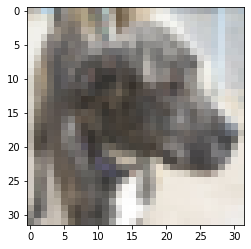

In [ ]:
# mostrando una imagen aleatoriamente
id=np.random.randint(0,len(train_ds),size=1)[0]
print(train_ds[id][1])
plt.imshow(train_ds[id][0].numpy().transpose(1,2,0))

Data loading is one of the first steps in building a Deep Learning pipeline, or training a model. This task becomes more challenging when the complexity of the data increases.



shuffle is another argument passed to the DataLoader class. The argument takes in a Boolean value (True/False). If shuffle is set to True, then all the samples are shuffled and loaded in batches. Otherwise they are sent one-by-one without any shuffling.

In [ ]:
# creando el batch size para el entrenamiento, usando la data completa
batch=2**5
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=batch, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=batch, shuffle=True)

In [ ]:
# creando el batch con una parte de la data
train_dl_2 = torch.utils.data.DataLoader(train_ds_2,batch_size=batch,shuffle=True)
test_dl_2 = torch.utils.data.DataLoader(test_ds_2,batch_size=batch,shuffle=True)

clase: tensor(1)


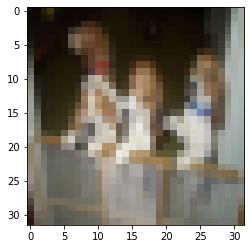

clase: tensor(1)


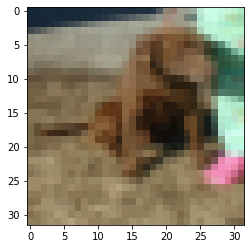

In [ ]:
#mostrando una imagen aleatoria del batch 
k=0
for x,y in test_dl_2:
  if k>1:
    break
  k=k+1
  id=np.random.randint(0,len(x),size=1)[0]
  print("clase:",y[id])
  plt.imshow(x[id].numpy().transpose(1,2,0))
  plt.show()

#Método de entrenamiento y evalucaion

In [ ]:
def evaluate(model, loader, crit):
  model.eval()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in loader:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100* corrects / total
  avg_loss /= len(loader)  
  return avg_loss, acc


def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100 * corrects / total
  avg_loss /= len(train_loader)
  return avg_loss, acc

def train(model, train_loader, test_loader, crit, optim, epochs = 20):
  
  ######### variables para la grafica
  epocar=[]
  train_lossr=[]
  train_accr=[]
  test_lossr=[]
  test_accr=[]
  ########################

  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader,crit, optim)
    test_loss, test_acc = evaluate(model, test_loader, crit)
    print("finalizacion de la epoch : ",epoch)
    #print(f"epoch: {epoch}, train loss: {train_loss}, train acc: {train_acc}%, test loss: {test_loss}, test acc: {test_acc}%")
    
    ####### datos para la grafica
    epocar.append(epoch)
    train_lossr.append(train_loss)
    train_accr.append(train_acc)
    test_lossr.append(test_loss)
    test_accr.append(test_acc)
    ####################
  
  #### mostrando las graficas
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(221)
  ax.plot(epocar,train_lossr,'o-',label="train_loss")
  plt.grid(True)
  ax.set_title("train_loss")
  ax2 = fig.add_subplot(222)
  ax2.plot(epocar,train_accr,'o-',label="train_acc")
  plt.grid(True)
  ax2.set_title("train_acc")
  ax3 = fig.add_subplot(223)
  ax3.plot(epocar,test_lossr,'o-',label="test_loss")
  plt.grid(True)
  ax3.set_title("test_loss")
  ax4 = fig.add_subplot(224)
  ax4.plot(epocar,test_accr,'o-',label="train_loss")
  plt.grid(True)
  ax4.set_title("test_cc")
  plt.show()
  #############

    

#Modelo

In [ ]:
#### modelo basico lineal
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(new_dim**2*3,new_dim**2*2),
    nn.ReLU(inplace=True),
    nn.Linear(new_dim**2*2,new_dim**2),
    nn.ReLU(inplace=True),
    nn.Linear(new_dim**2,new_dim*50),
    nn.ReLU(inplace=True),  
    nn.Linear(new_dim*50,new_dim*10),
    nn.ReLU(inplace=True),
    nn.Linear(new_dim*10, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 2)
).to(dev)

In [ ]:
# bloque residual basico
class BasicResBlock(nn.Module):
  def __init__(self,in_planes, out_planes, kernel_size=3, stride=1,padding=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size,stride=stride,padding=padding,bias=False)
    self.bn1 = nn.BatchNorm2d(out_planes)
    self.relu1 = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=kernel_size,stride=1,padding=padding,bias=False)
    self.bn2 = nn.BatchNorm2d(out_planes)
    self.relu2 = nn.ReLU()
    self.shortcut = nn.Sequential()
    if stride > 1 or in_planes != out_planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes,out_planes,kernel_size=1,stride=stride,padding=0,bias=False),
          nn.BatchNorm2d(out_planes)
      )
  def forward(self,x):
    o = self.conv1(x)
    o = self.bn1(o)
    o = self.relu1(o)
    o = self.conv2(o)
    o = self.bn2(o)
    o = self.relu2(self.shortcut(x) + o)
    return o

In [ ]:
# modelo aplicando bloques residuales
cifar10_model = nn.Sequential(
    BasicResBlock(3,16),
    nn.MaxPool2d(kernel_size=2),
    BasicResBlock(16,32),
    nn.MaxPool2d(kernel_size=2),
    BasicResBlock(32,64),
    nn.MaxPool2d(kernel_size=2),
    BasicResBlock(64,128),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(512,128),
    nn.ReLU(inplace=True),
    nn.Linear(128,2)
).to(dev)

## Entrenamiento



finalizacion de la epoch :  0
finalizacion de la epoch :  1
finalizacion de la epoch :  2
finalizacion de la epoch :  3
finalizacion de la epoch :  4
finalizacion de la epoch :  5
finalizacion de la epoch :  6
finalizacion de la epoch :  7
finalizacion de la epoch :  8
finalizacion de la epoch :  9
finalizacion de la epoch :  10
finalizacion de la epoch :  11
finalizacion de la epoch :  12
finalizacion de la epoch :  13
finalizacion de la epoch :  14
finalizacion de la epoch :  15
finalizacion de la epoch :  16
finalizacion de la epoch :  17
finalizacion de la epoch :  18
finalizacion de la epoch :  19


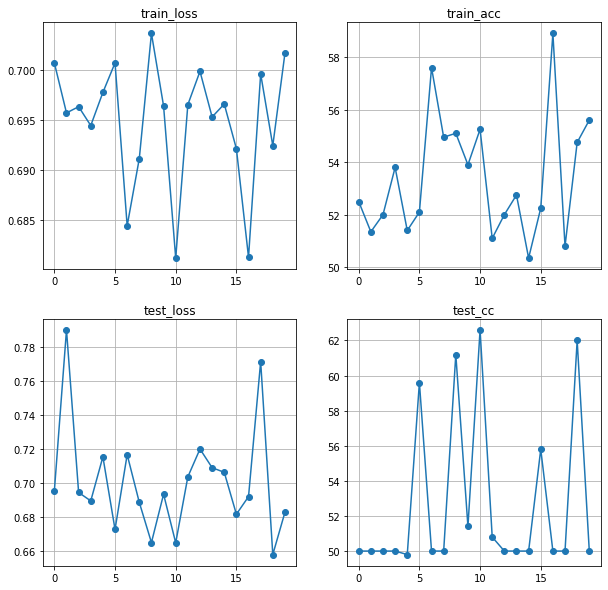

In [ ]:
# evaluacion del primero modelo
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=1)
train(model,train_dl_2, test_dl_2, crit, optim, epochs=20)

finalizacion de la epoch :  0
finalizacion de la epoch :  1
finalizacion de la epoch :  2
finalizacion de la epoch :  3
finalizacion de la epoch :  4
finalizacion de la epoch :  5
finalizacion de la epoch :  6
finalizacion de la epoch :  7
finalizacion de la epoch :  8
finalizacion de la epoch :  9
finalizacion de la epoch :  10
finalizacion de la epoch :  11
finalizacion de la epoch :  12
finalizacion de la epoch :  13
finalizacion de la epoch :  14
finalizacion de la epoch :  15
finalizacion de la epoch :  16
finalizacion de la epoch :  17
finalizacion de la epoch :  18
finalizacion de la epoch :  19


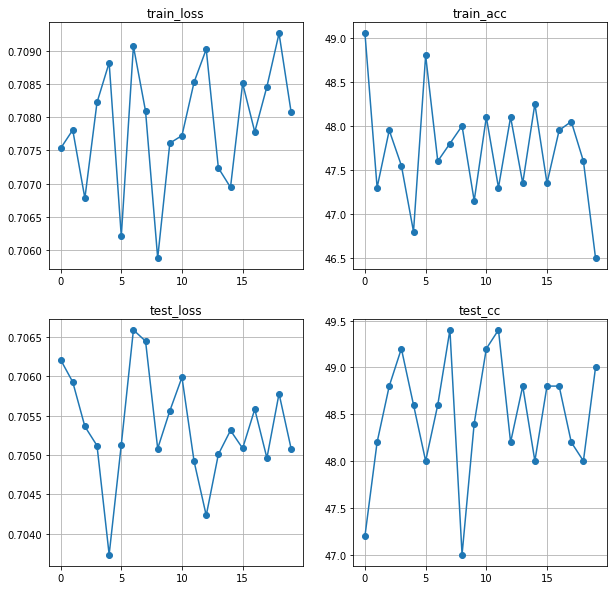

In [ ]:
# evaluacion del segundo modelo
train(cifar10_model,train_dl_2, test_dl_2, crit, optim, epochs=20)

https://medium.com/swlh/cross-entropy-loss-in-pytorch-c010faf97bab

http://haokailong.top/2020/11/19/torch-nn-CrossEntropyLoss/

#Evaluación

2000


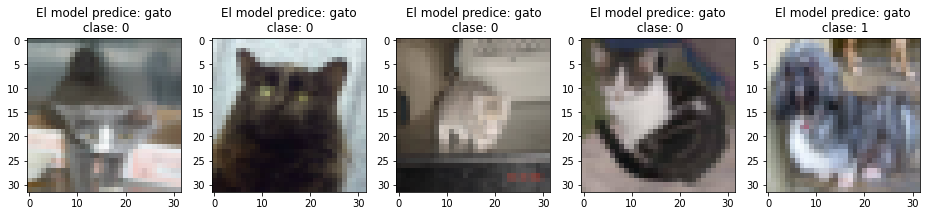

In [ ]:
model_label = ["gato", "perro"]
print(len(test_ds))
N = 5
fig, axs = plt.subplots(1,N,figsize=(16,8))

for i in range(N):
  idx = np.random.randint(0,len(test_ds),size=1)[0]
  x, y = test_ds[idx]
  x_numpy = x.numpy().transpose(1,2,0)
  N, H, W = x.shape
  x = x.reshape(1,N,H,W)
  pred = torch.argmax(model(x.to(dev)).cpu()).item()
  axs[i].imshow(x.cpu().reshape(3,32,32).numpy().transpose(1,2,0))
  axs[i].set_title(f"El model predice: {model_label[torch.argmax(model(x.to(dev)))]}\n clase: {y}")
plt.savefig("evaluacion_model1.png")

2000


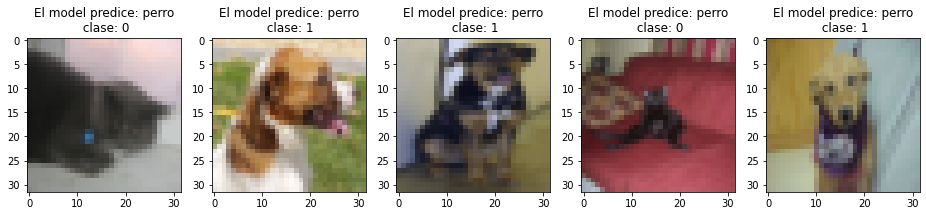

In [ ]:
cifar10_labels = ["gato", "perro"]
print(len(test_ds))
N = 5
fig, axs = plt.subplots(1,N,figsize=(16,8))

for i in range(N):
  idx = np.random.randint(0,len(test_ds),size=1)[0]
  x, y = test_ds[idx]
  x_numpy = x.numpy().transpose(1,2,0)
  N, H, W = x.shape
  x = x.reshape(1,N,H,W)
  pred = torch.argmax(cifar10_model(x.to(dev)).cpu()).item()
  axs[i].imshow(x.cpu().reshape(3,32,32).numpy().transpose(1,2,0))
  axs[i].set_title(f"El model predice: {cifar10_labels[torch.argmax(cifar10_model(x.to(dev)))]}\n clase: {y}")
plt.savefig("evaluacion_model2.png")